#**Load the EEG Data**

In [1]:
import h5py
import numpy as np

# Open the v7.3 MAT file
with h5py.File('03_2_raw.mat', 'r') as f:
    # List all keys (variables stored in the file)
    print("Keys in file:", list(f.keys()))

    # Load EEG data
    eeg_data = np.array(f['X'])  # Adjust key name if different

    # Load sampling frequency
    sampling_frequency = np.array(f['fs'])[0][0]  # Usually stored like this

    # Load metadata
    din_metadata = np.array(f['DIN_1'])  # Adjust key if needed

# Print shapes and values
print(f"EEG Data Shape: {eeg_data.shape}")  # Expected: (129, time_points)
print(f"Sampling Frequency: {sampling_frequency} Hz")
print(f"DIN Metadata Shape: {din_metadata.shape}")

Keys in file: ['#refs#', 'DIN_1', 'X', 'fs']
EEG Data Shape: (1468373, 129)
Sampling Frequency: 1000.0 Hz
DIN Metadata Shape: (46, 4)


In [2]:
!pip install mne

Creating RawArray with float64 data, n_channels=129, n_times=1468373
    Range : 0 ... 1468372 =      0.000 ...  1468.372 secs
Ready.


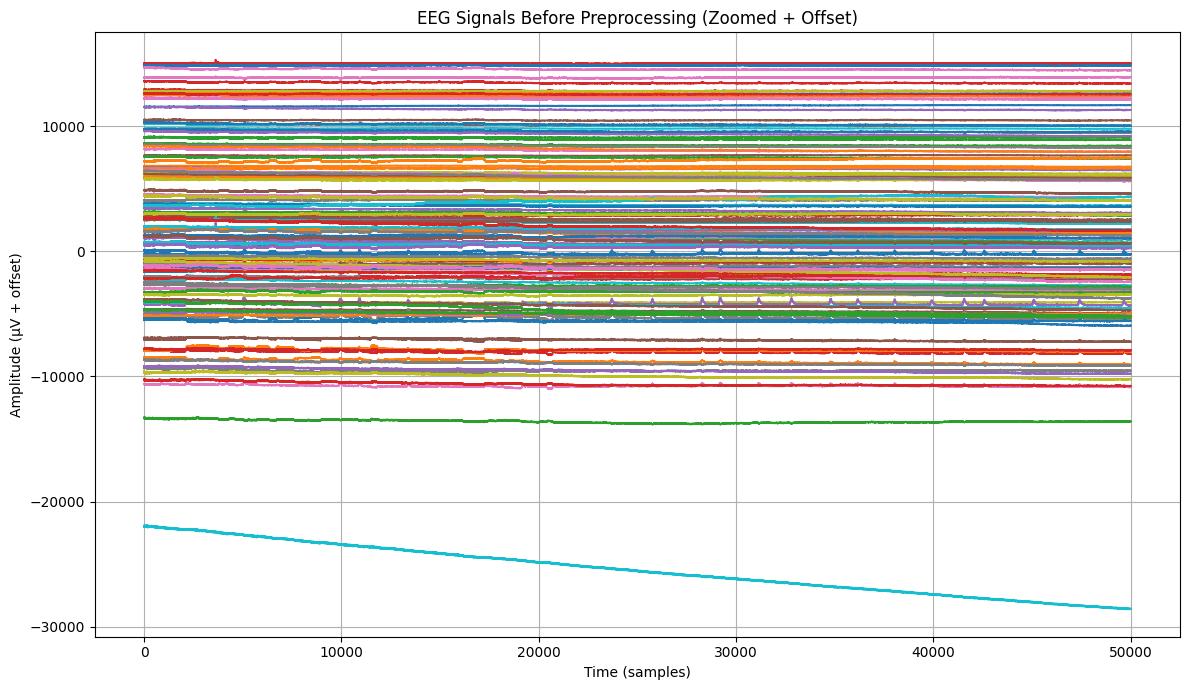

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mne import create_info
from mne.io import RawArray

# Step 1: Load EEG Data (Replace with actual loading code)
# Example EEG data shape: (time points x channels)
# Ensure you load 'eeg_data' and 'sampling_frequency' correctly.
# For now, assuming 'eeg_data' and 'sampling_frequency' are already loaded.

# Transpose EEG data if necessary (to match MNE format: channels x time points)
if eeg_data.shape[0] > eeg_data.shape[1]:  # Check if time points > channels
    eeg_data = eeg_data.T  # Transpose to (channels, time points)

# Scale data if values are too small (convert from volts to microvolts)
if np.max(np.abs(eeg_data)) < 1e-3:
    eeg_data = eeg_data * 1e6  # Convert from V to µV

# Step 2: Create MNE Info and Raw Object
info = create_info(ch_names=[f"Ch{i}" for i in range(eeg_data.shape[0])],
                   sfreq=sampling_frequency,
                   ch_types='eeg')
raw = RawArray(eeg_data, info)

# Step 3: Plot EEG Signals Before Preprocessing
plt.figure(figsize=(12, 7))

for i in range(eeg_data.shape[0]):  # Loop through all channels
    signal = eeg_data[i, :min(50000, eeg_data.shape[1])]  # Plot up to first 50000 samples
    plt.plot(signal + i * 100, label=f'Ch{i}')  # Offset for visibility

plt.title("EEG Signals Before Preprocessing (Zoomed + Offset)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (µV + offset)")
plt.grid(True)
plt.tight_layout()
plt.show()

#**Variance-Based Method**

In [13]:
from mne import create_info
from mne.io import RawArray
from mne.preprocessing import ICA
from mne.filter import filter_data

# 1. Load full EEG data (assuming it's still in variable: eeg_data shape: (129, time))
info_full = create_info(ch_names=[f"Ch{i}" for i in range(eeg_data.shape[0])],
                        sfreq=sampling_frequency,
                        ch_types='eeg')

# 2. High-pass filter the full EEG before ICA
filtered_full = filter_data(eeg_data, sfreq=sampling_frequency, l_freq=1.0, h_freq=None)
raw_filtered_full = RawArray(filtered_full, info_full)

# 3. Fit ICA on all 129 channels
ica = ICA(n_components=0.999999, random_state=42, max_iter=800)
ica.fit(raw_filtered_full)

# 4. Try auto-removal using virtual EOG from frontal EEG (e.g., Ch0 or Ch1)
eog_signal = raw_filtered_full.get_data(picks=[0])[0]
raw_with_eog = raw_filtered_full.copy()
raw_with_eog.add_channels([RawArray(eog_signal[np.newaxis, :],
                                    create_info(['EOG'], sampling_frequency, ['eog']))])

# 5. Auto-detect and remove EOG-related components
eog_inds, scores = ica.find_bads_eog(raw_with_eog, ch_name='EOG')
ica.exclude = eog_inds
print(f"❌ Excluding ICA Components: {ica.exclude}")

# 6. Apply ICA to original (unfiltered) full raw EEG
raw_full = RawArray(eeg_data, info_full)
cleaned_raw_full = raw_full.copy()
ica.apply(cleaned_raw_full)

# 7. Get cleaned EEG data (all 129 channels)
cleaned_full_eeg_data = cleaned_raw_full.get_data()

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.8s


Creating RawArray with float64 data, n_channels=129, n_times=1468373
    Range : 0 ... 1468372 =      0.000 ...  1468.372 secs
Ready.
Fitting ICA to data using 129 channels (please be patient, this may take a while)


<ipython-input-13-58a9a3b6714e>:17: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_filtered_full)


Selecting by explained variance: 128 components
Fitting ICA took 415.7s.
Creating RawArray with float64 data, n_channels=1, n_times=1468373
    Range : 0 ... 1468372 =      0.000 ...  1468.372 secs
Ready.
Using EOG channel: EOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    6.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

❌ Excluding ICA Components: [np.int64(0), np.int64(7), np.int64(2), np.int64(11), np.int64(3), np.int64(68), np.int64(15)]
Creating RawArray with float64 data, n_channels=129, n_times=1468373
    Range : 0 ... 1468372 =      0.000 ...  1468.372 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (128 components)
    Zeroing out 7 ICA components
    Projecting back using 129 PCA components


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Select top-k channels from cleaned EEG using variance
def select_channels_by_variance(eeg_data, num_channels=10):
    """
    Select top EEG channels with highest signal variance after preprocessing.
    """
    channel_variances = np.var(eeg_data, axis=1)
    selected_indices = np.argsort(channel_variances)[-num_channels:]  # top-k
    return eeg_data[selected_indices, :], selected_indices

# Apply variance selection on cleaned EEG
selected_eeg_data, selected_channels = select_channels_by_variance(cleaned_full_eeg_data, num_channels=10)
print(f"✅ Top {len(selected_channels)} High-Variance Channels Selected: {selected_channels}")

✅ Top 10 High-Variance Channels Selected: [14 38  8 56 16 20 13 24  7 39]


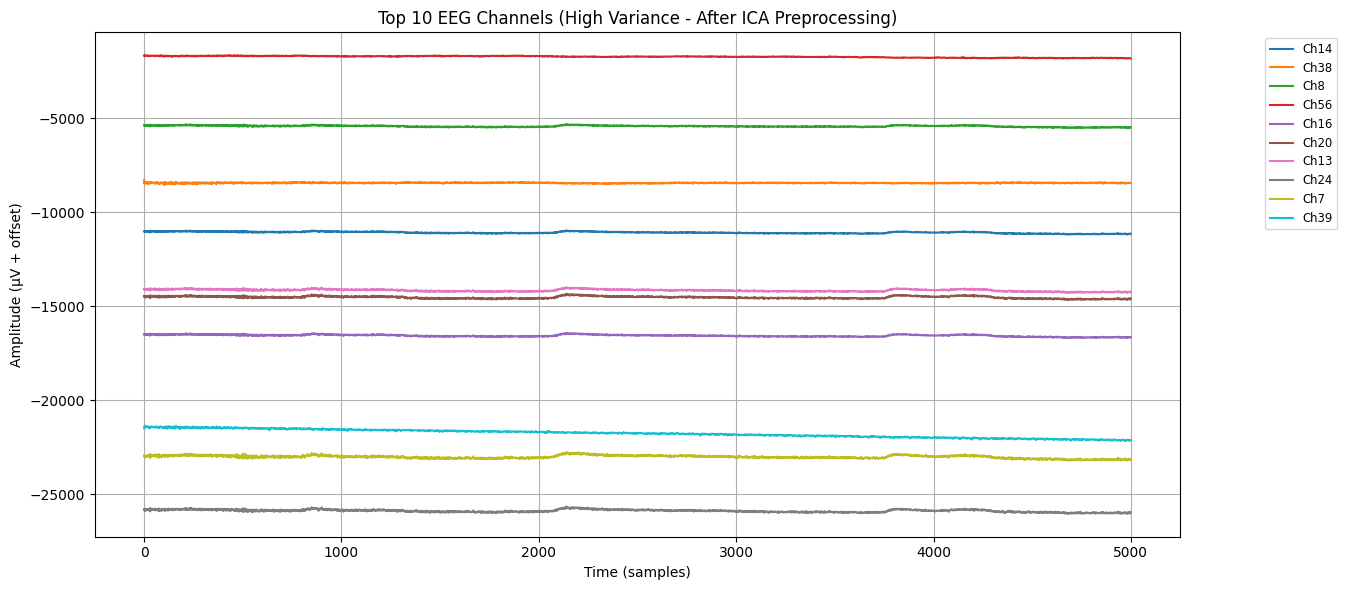

In [15]:
# Plot top 10 high-variance channels after ICA
plt.figure(figsize=(12, 6))
for i in range(selected_eeg_data.shape[0]):
    signal = selected_eeg_data[i, :5000]  # First 5 sec at 1000 Hz
    plt.plot(signal + i * 100, label=f"Ch{selected_channels[i]}")

plt.title("Top 10 EEG Channels (High Variance - After ICA Preprocessing)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (µV + offset)")
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')
plt.show()

In [16]:
import numpy as np

# -------------------------------
# 1. SNR Function
# -------------------------------
def calculate_snr(signal):
    signal_power = np.mean(signal ** 2)
    noise_power = np.var(signal)
    if noise_power == 0:
        return float('-inf')  # avoid division by 0
    return 10 * np.log10(signal_power / noise_power)

# -------------------------------
# 2. Select Top Channels by Variance (Before ICA)
# -------------------------------
def select_channels_by_variance(eeg_data, num_channels=10):
    variances = np.var(eeg_data, axis=1)
    top_indices = np.argsort(variances)[-num_channels:]
    return eeg_data[top_indices, :], top_indices

# Select raw + cleaned data
raw_selected, selected_indices = select_channels_by_variance(eeg_data, num_channels=10)
cleaned_selected = cleaned_full_eeg_data[selected_indices, :]

# -------------------------------
# 3. Calculate SNRs
# -------------------------------
snrs_before = [calculate_snr(raw_selected[i]) for i in range(10)]
snrs_after = [calculate_snr(cleaned_selected[i]) for i in range(10)]

# -------------------------------
# 4. Print Results
# -------------------------------
print("\n📊 Per-Channel SNR (Variance Method):\n")
for i, ch in enumerate(selected_indices):
    print(f"Channel {ch:>3} | SNR Before ICA: {snrs_before[i]:6.2f} dB | After ICA: {snrs_after[i]:6.2f} dB")

print("\n📈 Overall SNR Summary (Variance-Based Selection):")
print(f"✅ Mean SNR Before ICA: {np.mean(snrs_before):.2f} dB")
print(f"✅ Mean SNR After ICA : {np.mean(snrs_after):.2f} dB")
print(f"📈 SNR Improvement     : {np.mean(snrs_after) - np.mean(snrs_before):.2f} dB")


📊 Per-Channel SNR (Variance Method):

Channel  11 | SNR Before ICA:   7.79 dB | After ICA:  32.46 dB
Channel  12 | SNR Before ICA:   0.51 dB | After ICA:   1.01 dB
Channel   9 | SNR Before ICA:   4.22 dB | After ICA:  14.30 dB
Channel 105 | SNR Before ICA:  13.03 dB | After ICA:  12.65 dB
Channel  57 | SNR Before ICA:  13.33 dB | After ICA:   8.79 dB
Channel  38 | SNR Before ICA:  16.96 dB | After ICA:  13.26 dB
Channel  42 | SNR Before ICA:  19.47 dB | After ICA:  18.53 dB
Channel  18 | SNR Before ICA:   0.75 dB | After ICA:  14.47 dB
Channel  56 | SNR Before ICA:   8.20 dB | After ICA:   1.10 dB
Channel  39 | SNR Before ICA:  10.61 dB | After ICA:  10.19 dB

📈 Overall SNR Summary (Variance-Based Selection):
✅ Mean SNR Before ICA: 9.49 dB
✅ Mean SNR After ICA : 12.68 dB
📈 SNR Improvement     : 3.19 dB


#**Correlation-Based Method**

In [4]:
from mne import create_info
from mne.io import RawArray
from mne.preprocessing import ICA
from mne.filter import filter_data

# 1. Create MNE Info for full EEG
info_full = create_info(ch_names=[f"Ch{i}" for i in range(eeg_data.shape[0])],
                        sfreq=sampling_frequency,
                        ch_types='eeg')

# 2. High-pass filter before ICA
filtered_full = filter_data(eeg_data, sfreq=sampling_frequency, l_freq=1.0, h_freq=None)
raw_filtered_full = RawArray(filtered_full, info_full)

# 3. Fit ICA
ica = ICA(n_components=0.999999, random_state=42, max_iter=800)
ica.fit(raw_filtered_full)

# 4. Simulated EOG for artifact detection
eog_signal = raw_filtered_full.get_data(picks=[0])[0]
raw_with_eog = raw_filtered_full.copy()
raw_with_eog.add_channels([
    RawArray(eog_signal[np.newaxis, :], create_info(['EOG'], sampling_frequency, ['eog']))
])
eog_inds, _ = ica.find_bads_eog(raw_with_eog, ch_name='EOG')
ica.exclude = eog_inds
print(f"❌ Excluding ICA Components (EOG): {ica.exclude}")

# 5. Apply ICA to original raw EEG (unfiltered)
raw_full = RawArray(eeg_data, info_full)
cleaned_raw_full = raw_full.copy()
ica.apply(cleaned_raw_full)

# 6. Get cleaned EEG data (129 channels x time)
cleaned_full_eeg_data = cleaned_raw_full.get_data()

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:   11.2s


Creating RawArray with float64 data, n_channels=129, n_times=1468373
    Range : 0 ... 1468372 =      0.000 ...  1468.372 secs
Ready.
Fitting ICA to data using 129 channels (please be patient, this may take a while)


<ipython-input-4-6219357ae588>:17: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_filtered_full)


Selecting by explained variance: 128 components
Fitting ICA took 1232.4s.
Creating RawArray with float64 data, n_channels=1, n_times=1468373
    Range : 0 ... 1468372 =      0.000 ...  1468.372 secs
Ready.
Using EOG channel: EOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    5.9s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

❌ Excluding ICA Components (EOG): [np.int64(0), np.int64(7), np.int64(2), np.int64(11), np.int64(3), np.int64(68), np.int64(15)]
Creating RawArray with float64 data, n_channels=129, n_times=1468373
    Range : 0 ... 1468372 =      0.000 ...  1468.372 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (128 components)
    Zeroing out 7 ICA components
    Projecting back using 129 PCA components


In [6]:
# Select top-k least-correlated channels
def select_channels_by_correlation(eeg_data, num_channels=10):
    """
    Selects EEG channels with lowest average correlation to others.
    """
    corr_matrix = np.corrcoef(eeg_data)  # shape: (129, 129)
    np.fill_diagonal(corr_matrix, 0)  # ignore self-correlation

    avg_corr = np.mean(np.abs(corr_matrix), axis=1)  # average correlation for each channel
    selected_indices = np.argsort(avg_corr)[:num_channels]  # least correlated = most unique
    return eeg_data[selected_indices, :], selected_indices

# Apply correlation-based selection
selected_eeg_data, selected_channels = select_channels_by_correlation(cleaned_full_eeg_data, 10)
print(f"✅ Top 10 Least-Correlated Channels Selected: {selected_channels}")

✅ Top 10 Least-Correlated Channels Selected: [89 81 82 83 84 85 86 87 88 80]


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


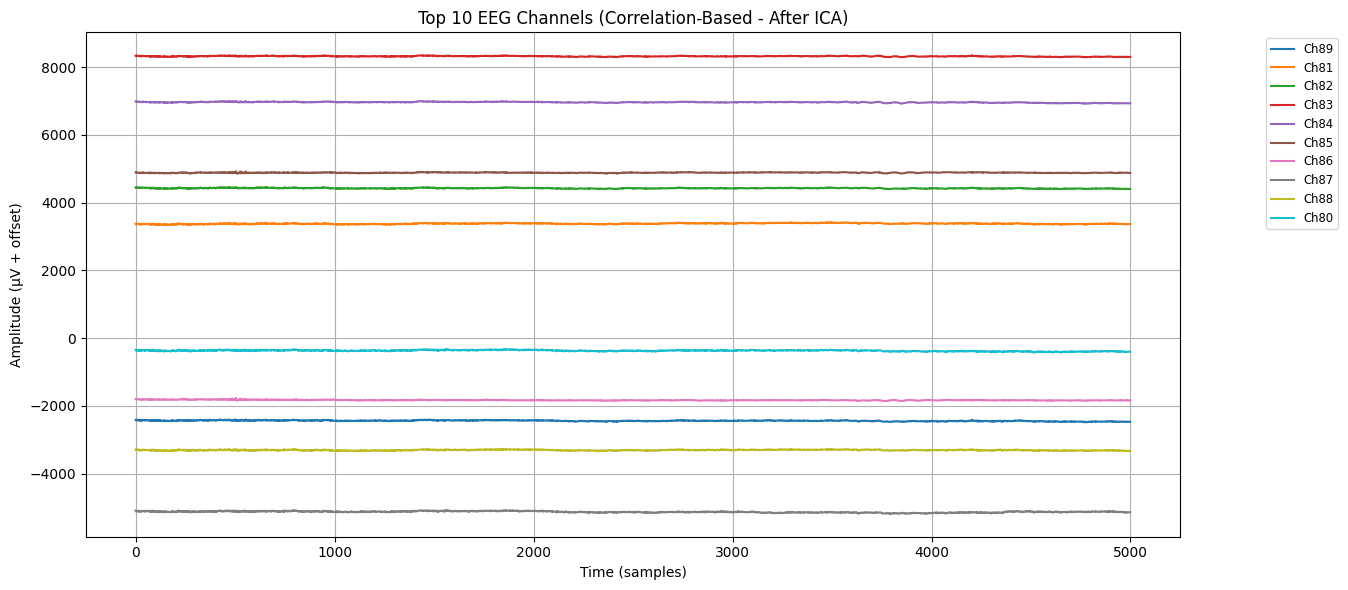

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(selected_eeg_data.shape[0]):
    signal = selected_eeg_data[i, :5000]
    plt.plot(signal + i * 100, label=f"Ch{selected_channels[i]}")

plt.title("Top 10 EEG Channels (Correlation-Based - After ICA)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (µV + offset)")
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')
plt.show()

In [8]:
# Use original raw EEG and ICA-cleaned EEG to compare SNR
raw_selected, _ = select_channels_by_correlation(eeg_data, num_channels=10)
cleaned_selected, selected_indices = select_channels_by_correlation(cleaned_full_eeg_data, num_channels=10)

# SNR function (same)
def calculate_snr(signal):
    signal_power = np.mean(signal ** 2)
    noise_power = np.var(signal)
    if noise_power == 0:
        return float('-inf')
    return 10 * np.log10(signal_power / noise_power)

snrs_before = [calculate_snr(raw_selected[i]) for i in range(10)]
snrs_after = [calculate_snr(cleaned_selected[i]) for i in range(10)]

# Print results
print("\n📊 Per-Channel SNR (Correlation Method):\n")
for i, ch in enumerate(selected_indices):
    print(f"Channel {ch:>3} | SNR Before ICA: {snrs_before[i]:6.2f} dB | After ICA: {snrs_after[i]:6.2f} dB")

print("\n📈 Overall SNR Summary (Correlation-Based Selection):")
print(f"✅ Mean SNR Before ICA: {np.mean(snrs_before):.2f} dB")
print(f"✅ Mean SNR After ICA : {np.mean(snrs_after):.2f} dB")
print(f"📈 SNR Improvement     : {np.mean(snrs_after) - np.mean(snrs_before):.2f} dB")


📊 Per-Channel SNR (Correlation Method):

Channel  89 | SNR Before ICA:  20.00 dB | After ICA:  12.50 dB
Channel  81 | SNR Before ICA:  12.47 dB | After ICA:  12.22 dB
Channel  82 | SNR Before ICA:   4.72 dB | After ICA:  12.31 dB
Channel  83 | SNR Before ICA:  30.30 dB | After ICA:  30.08 dB
Channel  84 | SNR Before ICA:  23.42 dB | After ICA:  28.45 dB
Channel  85 | SNR Before ICA:  18.73 dB | After ICA:  28.54 dB
Channel  86 | SNR Before ICA:  21.64 dB | After ICA:  15.84 dB
Channel  87 | SNR Before ICA:  28.53 dB | After ICA:  22.70 dB
Channel  88 | SNR Before ICA:  26.87 dB | After ICA:  17.55 dB
Channel  80 | SNR Before ICA:  19.84 dB | After ICA:   9.83 dB

📈 Overall SNR Summary (Correlation-Based Selection):
✅ Mean SNR Before ICA: 20.65 dB
✅ Mean SNR After ICA : 19.00 dB
📈 SNR Improvement     : -1.65 dB


#**Genetic Algorithm Method**

In [7]:
from mne import create_info
from mne.io import RawArray
from mne.preprocessing import ICA
from mne.filter import filter_data

info_full = create_info(ch_names=[f"Ch{i}" for i in range(eeg_data.shape[0])],
                        sfreq=sampling_frequency,
                        ch_types='eeg')

# Filter before ICA
filtered_full = filter_data(eeg_data, sfreq=sampling_frequency, l_freq=1.0, h_freq=None)
raw_filtered_full = RawArray(filtered_full, info_full)

# Fit ICA
ica = ICA(n_components=0.999999, random_state=42, max_iter=800)
ica.fit(raw_filtered_full)

# Simulated EOG for artifact detection
eog_signal = raw_filtered_full.get_data(picks=[0])[0]
raw_with_eog = raw_filtered_full.copy()
raw_with_eog.add_channels([
    RawArray(eog_signal[np.newaxis, :], create_info(['EOG'], sampling_frequency, ['eog']))
])
eog_inds, _ = ica.find_bads_eog(raw_with_eog, ch_name='EOG')
ica.exclude = eog_inds
print(f"❌ ICA Components Excluded: {ica.exclude}")

# Apply ICA to unfiltered data
raw_full = RawArray(eeg_data, info_full)
cleaned_raw_full = raw_full.copy()
ica.apply(cleaned_raw_full)

# Final cleaned EEG: (129 x time)
cleaned_full_eeg_data = cleaned_raw_full.get_data()

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    5.2s


Creating RawArray with float64 data, n_channels=129, n_times=1468373
    Range : 0 ... 1468372 =      0.000 ...  1468.372 secs
Ready.
Fitting ICA to data using 129 channels (please be patient, this may take a while)


<ipython-input-7-f26dea60b6b1>:16: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_filtered_full)


Selecting by explained variance: 128 components
Fitting ICA took 1228.6s.
Creating RawArray with float64 data, n_channels=1, n_times=1468373
    Range : 0 ... 1468372 =      0.000 ...  1468.372 secs
Ready.
Using EOG channel: EOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    5.7s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

❌ ICA Components Excluded: [np.int64(0), np.int64(7), np.int64(2), np.int64(11), np.int64(3), np.int64(68), np.int64(15)]
Creating RawArray with float64 data, n_channels=129, n_times=1468373
    Range : 0 ... 1468372 =      0.000 ...  1468.372 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (128 components)
    Zeroing out 7 ICA components
    Projecting back using 129 PCA components


In [8]:
import numpy as np
import random

# Fitness function: mean SNR of selected channels
def calculate_snr(signal):
    signal_power = np.mean(signal ** 2)
    noise_power = np.var(signal)
    if noise_power == 0:
        return float('-inf')
    return 10 * np.log10(signal_power / noise_power)

def evaluate_subset(data, channels):
    subset = data[channels, :]
    snrs = [calculate_snr(subset[i]) for i in range(len(channels))]
    return np.mean(snrs)

# GA Parameters
NUM_CHANNELS = 129
SUBSET_SIZE = 10
POP_SIZE = 30
GENERATIONS = 20
MUTATION_RATE = 0.2

# Initialize population
def generate_population():
    return [sorted(random.sample(range(NUM_CHANNELS), SUBSET_SIZE)) for _ in range(POP_SIZE)]

# Crossover
def crossover(p1, p2):
    child = list(set(p1[:SUBSET_SIZE//2] + p2[SUBSET_SIZE//2:]))
    while len(child) < SUBSET_SIZE:
        new_gene = random.randint(0, NUM_CHANNELS - 1)
        if new_gene not in child:
            child.append(new_gene)
    return sorted(child[:SUBSET_SIZE])

# Mutation
def mutate(individual):
    if random.random() < MUTATION_RATE:
        i = random.randint(0, SUBSET_SIZE - 1)
        new_gene = random.randint(0, NUM_CHANNELS - 1)
        while new_gene in individual:
            new_gene = random.randint(0, NUM_CHANNELS - 1)
        individual[i] = new_gene
    return sorted(individual)

# GA Loop
population = generate_population()
for gen in range(GENERATIONS):
    fitness_scores = [(evaluate_subset(cleaned_full_eeg_data, individual), individual) for individual in population]
    fitness_scores.sort(reverse=True)
    print(f"Generation {gen+1} - Best SNR: {fitness_scores[0][0]:.2f} dB")

    top_individuals = [ind for _, ind in fitness_scores[:POP_SIZE // 2]]
    new_population = top_individuals[:]
    while len(new_population) < POP_SIZE:
        p1, p2 = random.sample(top_individuals, 2)
        child = crossover(p1, p2)
        child = mutate(child)
        new_population.append(child)
    population = new_population

# Final best channel subset
best_snr, best_channels = max([(evaluate_subset(cleaned_full_eeg_data, individual), individual) for individual in population])
selected_channels = best_channels
selected_eeg_data = cleaned_full_eeg_data[selected_channels, :]
print(f"\n✅ GA Selected Channels: {selected_channels}")

Generation 1 - Best SNR: 20.92 dB
Generation 2 - Best SNR: 21.25 dB
Generation 3 - Best SNR: 21.68 dB
Generation 4 - Best SNR: 21.68 dB
Generation 5 - Best SNR: 22.13 dB
Generation 6 - Best SNR: 25.12 dB
Generation 7 - Best SNR: 25.12 dB
Generation 8 - Best SNR: 25.12 dB
Generation 9 - Best SNR: 25.12 dB
Generation 10 - Best SNR: 25.12 dB
Generation 11 - Best SNR: 25.12 dB
Generation 12 - Best SNR: 25.12 dB
Generation 13 - Best SNR: 25.12 dB
Generation 14 - Best SNR: 25.12 dB
Generation 15 - Best SNR: 25.12 dB
Generation 16 - Best SNR: 25.12 dB
Generation 17 - Best SNR: 25.12 dB
Generation 18 - Best SNR: 25.12 dB
Generation 19 - Best SNR: 25.12 dB
Generation 20 - Best SNR: 25.12 dB

✅ GA Selected Channels: [4, 10, 29, 36, 43, 45, 71, 72, 83, 103]


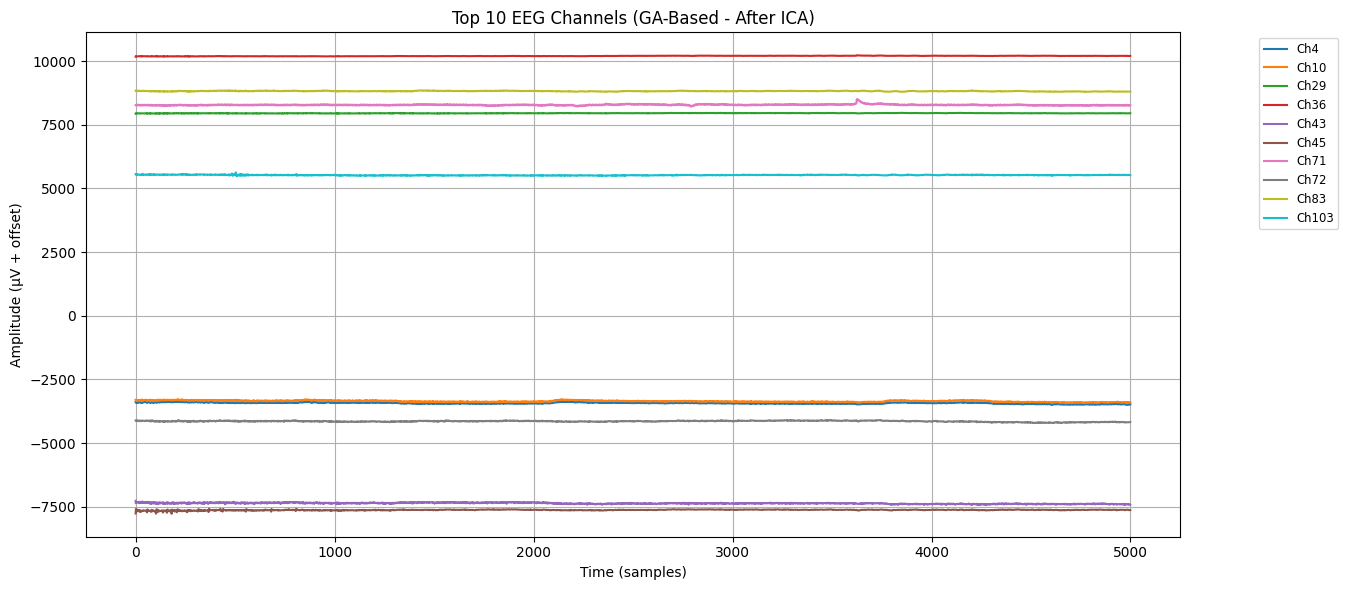

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(selected_eeg_data.shape[0]):
    signal = selected_eeg_data[i, :5000]
    plt.plot(signal + i * 100, label=f"Ch{selected_channels[i]}")

plt.title("Top 10 EEG Channels (GA-Based - After ICA)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (µV + offset)")
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')
plt.show()

In [10]:
# Evaluate same GA-selected channels in raw EEG (before ICA)
raw_selected = eeg_data[selected_channels, :]
cleaned_selected = selected_eeg_data  # Already cleaned by ICA

snrs_before = [calculate_snr(raw_selected[i]) for i in range(10)]
snrs_after = [calculate_snr(cleaned_selected[i]) for i in range(10)]

print("\n📊 Per-Channel SNR (GA Method):\n")
for i, ch in enumerate(selected_channels):
    print(f"Channel {ch:>3} | SNR Before ICA: {snrs_before[i]:6.2f} dB | After ICA: {snrs_after[i]:6.2f} dB")

print("\n📈 Overall SNR Summary (GA-Based Selection):")
print(f"✅ Mean SNR Before ICA: {np.mean(snrs_before):.2f} dB")
print(f"✅ Mean SNR After ICA : {np.mean(snrs_after):.2f} dB")
print(f"📈 SNR Improvement     : {np.mean(snrs_after) - np.mean(snrs_before):.2f} dB")


📊 Per-Channel SNR (GA Method):

Channel   4 | SNR Before ICA:   1.04 dB | After ICA:  20.23 dB
Channel  10 | SNR Before ICA:   3.50 dB | After ICA:  17.51 dB
Channel  29 | SNR Before ICA:  24.00 dB | After ICA:  36.17 dB
Channel  36 | SNR Before ICA:  21.67 dB | After ICA:  23.69 dB
Channel  43 | SNR Before ICA:  31.13 dB | After ICA:  26.84 dB
Channel  45 | SNR Before ICA:  22.13 dB | After ICA:  18.86 dB
Channel  71 | SNR Before ICA:  26.19 dB | After ICA:  26.83 dB
Channel  72 | SNR Before ICA:  23.82 dB | After ICA:  17.56 dB
Channel  83 | SNR Before ICA:  30.30 dB | After ICA:  30.08 dB
Channel 103 | SNR Before ICA:  16.78 dB | After ICA:  35.53 dB

📈 Overall SNR Summary (GA-Based Selection):
✅ Mean SNR Before ICA: 20.06 dB
✅ Mean SNR After ICA : 25.33 dB
📈 SNR Improvement     : 5.28 dB


#**Best method based on SNR**

In [9]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# ✅ Step 1: Fill in your actual results here
methods = ['Variance-Based', 'Correlation-Based', 'GA-Based']
mean_before = [9.49, 20.65, 20.06]    # Replace with your real results
mean_after = [12.68, 19.00, 25.33]    # Replace with your real results
snr_gain = [after - before for before, after in zip(mean_before, mean_after)]

# ✅ Step 2: Create DataFrame
df = pd.DataFrame({
    'Method': methods,
    'Mean SNR Before ICA (dB)': mean_before,
    'Mean SNR After ICA (dB)': mean_after,
    'SNR Improvement (dB)': snr_gain
})

# ✅ Step 3: Identify the best method by highest SNR gain
best_index = np.argmax(snr_gain)
best_method = methods[best_index]
best_gain = snr_gain[best_index]

# ✅ Step 4: Format output beautifully
styled_df = df.style.set_table_attributes("style='display:inline'") \
    .set_caption("📊 Final Comparison of EEG Channel Selection Methods (Based on SNR)") \
    .apply(lambda x: ['font-weight: bold; background-color: #DFF0D8' if i == best_index else '' for i in range(len(x))], axis=0, subset=['SNR Improvement (dB)']) \
    .format({
        'Mean SNR Before ICA (dB)': '{:.2f}',
        'Mean SNR After ICA (dB)': '{:.2f}',
        'SNR Improvement (dB)': '{:.2f}'
    })

# ✅ Step 5: Display final results
display(Markdown("### ✅ EEG Channel Selection Comparison Summary"))
display(styled_df)
display(Markdown(f"""
### 🏆 **Best Method: `{best_method}`**
- **Highest SNR Improvement:** **{best_gain:.2f} dB**
- **Selection Basis:** Chosen based on **maximum average SNR improvement** after ICA.
- **SNR = Signal-to-Noise Ratio** — Higher values indicate better brain signal quality and artifact removal.
"""))

### ✅ EEG Channel Selection Comparison Summary

,Method,Mean SNR Before ICA (dB),Mean SNR After ICA (dB),SNR Improvement (dB)
0,Variance-Based,9.49,12.68,3.19
1,Correlation-Based,20.65,19.00,-1.65
2,GA-Based,20.06,25.33,5.27



### 🏆 **Best Method: `GA-Based`**
- **Highest SNR Improvement:** **5.27 dB**
- **Selection Basis:** Chosen based on **maximum average SNR improvement** after ICA.
- **SNR = Signal-to-Noise Ratio** — Higher values indicate better brain signal quality and artifact removal.
